In [1]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import re
import disallowedTermCheck
import urlRegExChecker
import emailRegExChecker

In [2]:
#parameters for deny list and url 
denyListURL = "denylist.csv"
notebookListURL ="notebooklist.csv"

In [3]:

#csv function ( to be implemented later)
#online dataset function (to be implemented later)

In [4]:

#notebook checker function 
def notebookChecker(denyListURL, notebookListURL):
    denyTerms = pd.read_csv('denylist.csv')
    deniedTerms = np.array(denyTerms)
    denyList = {}
    for terms in deniedTerms:
        denyList.update({terms[0]:terms[1]})
    # print (f"\n Here we check the terms and their corresponding weights {denyList} \n")    
    
    disallowedTerms = []
    for term in denyList.keys():
        disallowedTerms += [term]
    #print (f"\n here we assign the terms to be checked to a list {terms} \n")
    
    checkedNotebooks = {}
    
    notebookList = pd.read_csv('notebooklist.csv')
    uncheckedNotebooks = np.array(notebookList)
    print (f"\n Here we open and read the notebooks due to be open {uncheckedNotebooks} \n")
    

    #loop through files from list
    for uncheckedNotebook in uncheckedNotebooks:
        notebook = {}
        urlsFound = 0
        emailsFound = 0
        currentNotebook = open(str(f"notebookSamples/{uncheckedNotebook[0]}"), "r")
        # here we check line by line the the terms found which are added to a list 
        disallowedTermCount = {term : 0 for term in disallowedTerms}
        
        for line in currentNotebook:
            #loop trough line by line
            emailsFound += emailRegExChecker.emailChecker(line) 
            if urlRegExChecker.urlChecker(line) == True:
                urlsFound += 1

            checkedLine = disallowedTermCheck.termCheck(disallowedTerms, line)
            for term in checkedLine:
                if checkedLine[term] > 0:
                    disallowedTermCount[term] += 1
                    notebook.update({term: int(disallowedTermCount[term]) * int(denyList[term])}) 
                    checkedNotebooks.update({str(uncheckedNotebook): notebook})
        checkedNotebooks[str(uncheckedNotebook)]['urls'] = urlsFound
        checkedNotebooks[str(uncheckedNotebook)]['emails'] = emailsFound

    return checkedNotebooks 
    
    
notebookResults = notebookChecker(denyListURL, notebookListURL)
print(notebookResults)


 Here we open and read the notebooks due to be open [['sample.ipynb']
 ['sample2.ipynb']
 ['Lab03.ipynb']] 

{"['sample.ipynb']": {'security': 52, 'class': 9, 'people': 20, 'urls': 1, 'emails': 4}, "['sample2.ipynb']": {'security': 52, 'class': 9, 'people': 20, 'urls': 0, 'emails': 0}, "['Lab03.ipynb']": {'class': 36, 'urls': 8, 'emails': 0}}


{'sample': 86, 'sample2': 81, 'Lab03': 44}


<function matplotlib.pyplot.show(close=None, block=None)>

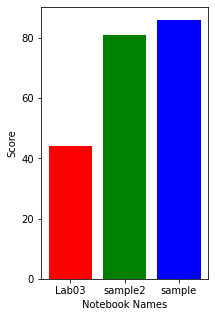

In [5]:
totals = {}

for nb in notebookResults:
    results = 0
    for term in notebookResults[nb]:
        results += notebookResults[nb][term]
    nb = nb.rsplit('.', 1)[0]
    nb = nb.rsplit('\'', 1)[1]
    totals[nb] = results
print(totals)
orderedResults = {term : score for term,score in sorted(totals.items(), key=lambda item:item[1])}

#PLot examples
f = plt.figure()
f.set_figwidth(3)
f.set_figheight(5)
plt.bar(range(len(orderedResults)),list(orderedResults.values()),align='center',color=['r','g','b'])
plt.xticks(range(len(orderedResults)),list(orderedResults.keys()))
plt.xlabel('Notebook Names')
plt.ylabel('Score')
plt.show

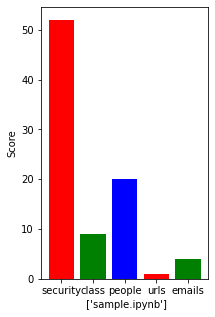

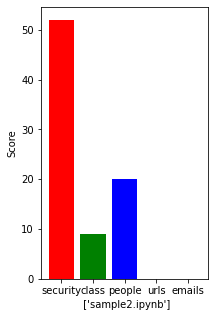

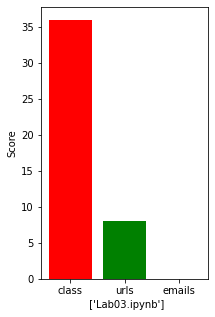

In [6]:
for result in notebookResults:
    terms = notebookResults[result]
    g = plt.figure()
    g.set_figwidth(3)
    g.set_figheight(5)
    plt.bar(range(len(terms)),list(terms.values()),align='center',color=['r','g','b'])
    plt.xticks(range(len(terms)),list(terms.keys()))
    plt.xlabel(f" {result}")
    plt.ylabel('Score')
    plt.show

In [7]:
#print in table
print('Notebook, terms found')
for k,v in notebookResults.items():
    print(k,v)

Notebook, terms found
['sample.ipynb'] {'security': 52, 'class': 9, 'people': 20, 'urls': 1, 'emails': 4}
['sample2.ipynb'] {'security': 52, 'class': 9, 'people': 20, 'urls': 0, 'emails': 0}
['Lab03.ipynb'] {'class': 36, 'urls': 8, 'emails': 0}


In [13]:
df = pd.DataFrame.from_dict(notebookResults, orient='index')
print('terms found:')
print(df)

terms found
                   security  class  people  urls  emails
['sample.ipynb']       52.0      9    20.0     1       4
['sample2.ipynb']      52.0      9    20.0     0       0
['Lab03.ipynb']         NaN     36     NaN     8       0


In [9]:
#do we add open CSV function
#do we add open dataset function 